# Basic implementation and sanity checks
This notebook shows the basic implementation of the algorithms for SVD. We test several algorithms:
- The first is the most intuitive, which takes the SVD of the dataset directly.
- The second is the same but with truncated modes.
- The third uses the QR decomposition to find the SVD of the dataset.
- The fourth uses a randomised algorithm to find the SVD of the dataset.
- The fifth uses a streaming algorithm to find the SVD of the dataset.

We test the algorithm on a simple dataset, and plot the first mode, time reconstruction and the singular values.
## Setup

First, import all the clobber and set up the plot parameters.



In [19]:
using LinearAlgebra
using GLMakie
GLMakie.activate!()
;


## Test function
We use a time varying hyperbolic secant function to generate a time series of matrices. The function is defined as follows:

$$
\begin{align*}
    f_1 &= \text{sech}(X - 2.5) \cdot 10 \cdot \cos(0.5 \cdot t) \\
    f_2 &= \cos(X) \cdot 1.0 \cdot \cos(2.5 \cdot t) \\
    f_3 &= \text{sech}(X - 15) \cdot 3 \cdot \cos(1 \cdot t) \\
    U &= f_1 + f_2 + f_3
\end{align*}
$$

This is an appropriate choice because it is periodic in time and has three distinct modes. We will also add some noise to ensure robustness of the algorithm.

In [20]:

m = 10000; n = 200; k = 4
t, x = range(0, stop=40, length=n), range(-10, stop=40, length=m)

Xgrid = [i for i in x, j in t]
tgrid = [j for i in x, j in t]

f1 = sech.(Xgrid.-2.5) .* 10.0 .* cos.(0.5 .*tgrid)
f2 = cos.(Xgrid) .* 1.0 .* cos.(2.5 .*tgrid)
f3 = sech.(Xgrid.-15.0) .* 3.0 .* cos.(1.0 .*tgrid)

Y = f1+f2+f3
Y = Y .+ 0.01 .* randn(size(Y))
;

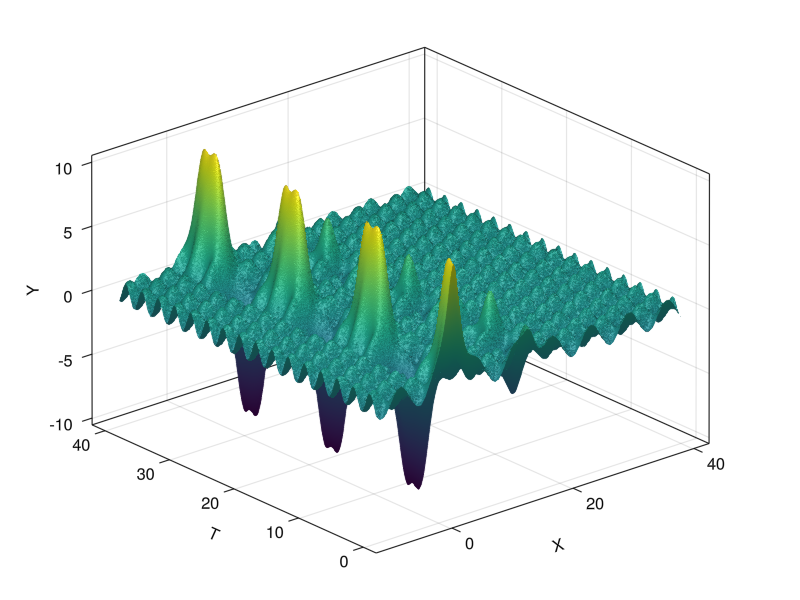

In [21]:
fig = Figure()
ax = Axis3(fig[1,1],xlabel="X",ylabel="T",zlabel="Y",)
surface!(ax, Xgrid, tgrid, Y)
fig

## Intuitive POD
Now we take the exact POD of the data. This is the simplest method with the least amount of steps. It is the method to beat when it comes to speed and accuracy.

In [22]:
U, Σ, V = svd(Y)
A = Diagonal(Σ)*V'  # Right multiply to get the modes
M1 = U[:,1:1] * A[1:1, :]  # Reconstruct in time
;

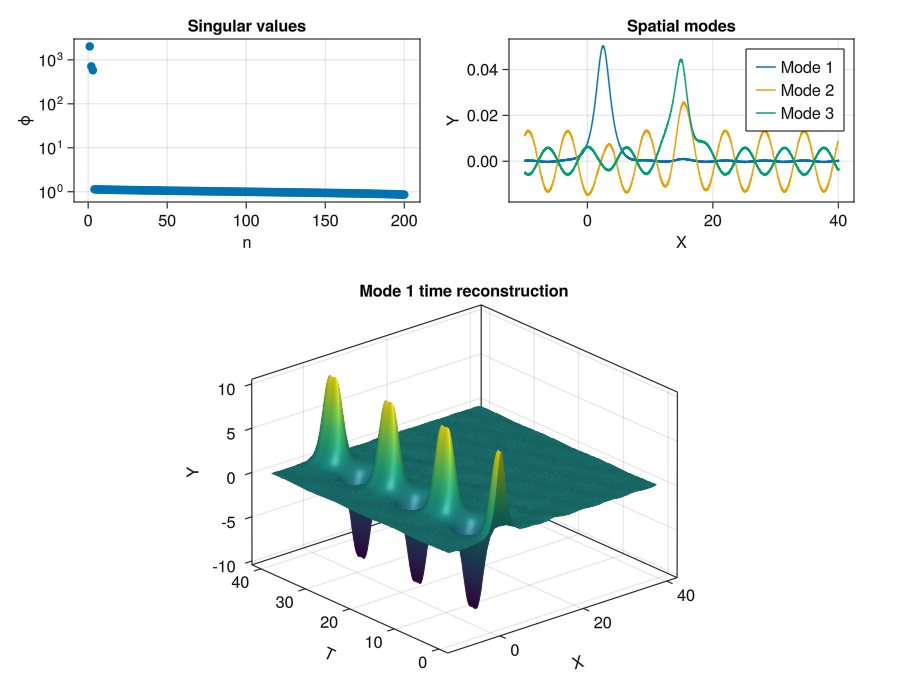

In [23]:
fig = Figure(resolution = (900, 700))
ax1 = Axis(fig[1,1],xlabel="n",ylabel="ϕ", title = "Singular values",yscale=log10,)
ax2 = Axis(fig[1,2],xlabel="X",ylabel="Y", title = "Spatial modes",)
ax3 = Axis3(fig[2:3,1:2],xlabel="X",ylabel="T",zlabel="Y", title = "Mode 1 time reconstruction",)
scatter!(ax1, Σ, label = "Singular values")
for i in 1:3
    lines!(ax2, Xgrid[:,1], U[:,i], label = "Mode $i")
end
surface!(ax3, Xgrid, tgrid, M1)

axislegend(ax2)
fig

### Truncated intuitive POD

In [24]:

U, Σ, V = svd(Y)
Uk = U[:, 1:k]
Σk = Σ[1:k]
Vk = V[:, 1:k]
A = Diagonal(Σk)*Vk'
M1 = Uk[:,1:1] * A[1:1, :]
;


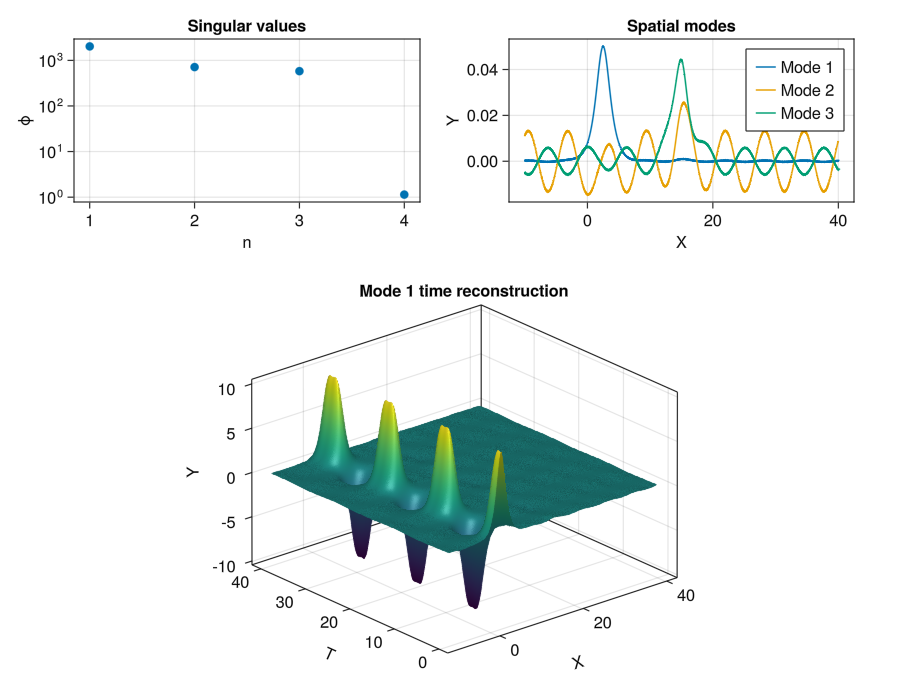

In [25]:
fig = Figure(resolution = (900, 700))
ax1 = Axis(fig[1,1],xlabel="n",ylabel="ϕ", title = "Singular values",yscale=log10,)
ax2 = Axis(fig[1,2],xlabel="X",ylabel="Y", title = "Spatial modes",)
ax3 = Axis3(fig[2:3,1:2],xlabel="X",ylabel="T",zlabel="Y", title = "Mode 1 time reconstruction",)

scatter!(ax1, Σk, label = "Singular values")
for i in 1:3
    lines!(ax2, Xgrid[:,1], Uk[:,i], label = "Mode $i")
end
surface!(ax3, Xgrid, tgrid, M1)

axislegend(ax2)
fig

## POD using the QR decomposition

Using the QR decomposition in the context of POD offers advantages such as providing an orthogonal basis, enabling rank reduction, ensuring numerical stability, offering computational efficiency, and facilitating interpretability. These benefits make it a valuable tool for dimensionality reduction.

In [26]:
Q,R = qr(Y)
B=transpose(Matrix(Q))*Y
Û,Σ,Vt=svd(B)
max_idx = sortperm(Σ, rev=true)[1:k]
Σk = Σ[max_idx]
Uk=Û[:, max_idx]
Vk=Vt'[max_idx, :]

U=Q*Uk

A = diagm(Σk) * Vk
M1 = U[:,1:1] * A[1:1, :]
;

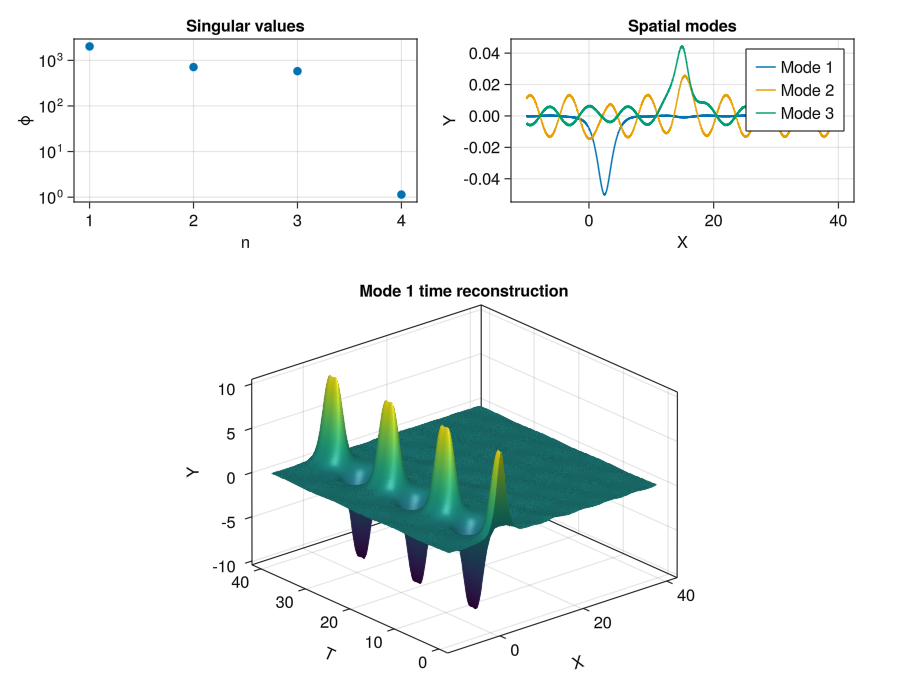

In [27]:
fig = Figure(resolution = (900, 700))
ax1 = Axis(fig[1,1],xlabel="n",ylabel="ϕ", title = "Singular values",yscale=log10,)
ax2 = Axis(fig[1,2],xlabel="X",ylabel="Y", title = "Spatial modes",)
ax3 = Axis3(fig[2:3,1:2],xlabel="X",ylabel="T",zlabel="Y", title = "Mode 1 time reconstruction",)
scatter!(ax1, Σ[1:k], label = "Singular values")
for i in 1:3
    lines!(ax2, Xgrid[:,1], U[:,i], label = "Mode $i")
end
surface!(ax3, Xgrid, tgrid, M1)

axislegend(ax2)
fig

## Randomised algorithm
This uses randomised linear algebra, specifically matrix sketching to approximate the SVD.

In [28]:
(m,n)=size(Y)
# Sketch the matrix
Phi=rand(n,k)
Yr=Y*Phi
Q,R = qr(Yr)
B=transpose(Matrix(Q))*Y
Û,Σ,Vt=svd(B)
max_idx = sortperm(Σ, rev=true)[1:k]
Σk = Σ[max_idx]
Uk=Û[:, max_idx]
Vk=Vt'[max_idx, :]
U=Matrix(Q)*Uk

A = diagm(Σk) * Vk
M1 = U[:,1:1] * A[1:1, :]
;

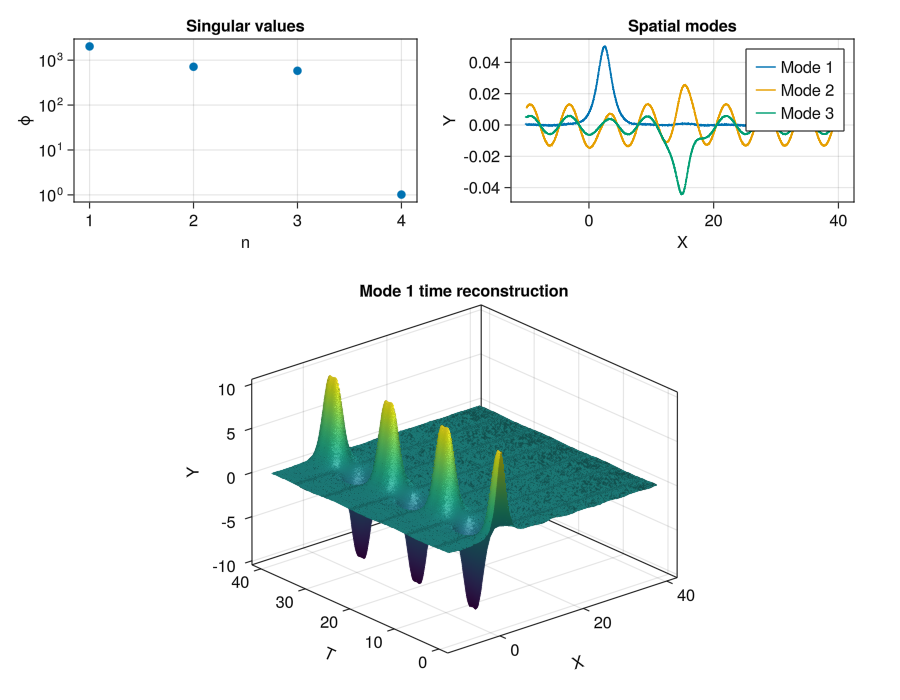

In [29]:
fig = Figure(resolution = (900, 700))
ax1 = Axis(fig[1,1],xlabel="n",ylabel="ϕ", title = "Singular values",yscale=log10,)
ax2 = Axis(fig[1,2],xlabel="X",ylabel="Y", title = "Spatial modes",)
ax3 = Axis3(fig[2:3,1:2],xlabel="X",ylabel="T",zlabel="Y", title = "Mode 1 time reconstruction",)
scatter!(ax1, Σ, label = "Singular values")
for i in 1:3
    lines!(ax2, Xgrid[:,1], U[:,i], label = "Mode $i")
end
surface!(ax3, Xgrid, tgrid, M1)

axislegend(ax2)
fig

## Streaming SVD algorithm

We split the data up into chunks, initialise the process, and then add the chunks one by one. This is the streaming SVD algorithm. The only downside is we can't reconstruct the whole time series because we need the whole dataset to do that.

In [30]:
m = size(Y, 2); chunk=2
Y1 = Y[:, 1:m÷chunk]
Y2 = Y[:, m÷chunk+1:2*m÷chunk]
;

In [31]:
# Initialise on the first chunk
Q,R = qr(Y1)
B=transpose(Matrix(Q))*Y1
Û,Σ,Vt=svd(B)
max_idx = sortperm(Σ, rev=true)[1:k]
Uk = Û[:, max_idx]
U=Matrix(Q)*Uk

# Incorporate the second chunk
m_ap = U
m_ap = hcat(m_ap, Y2)
Qi, Ri = qr(m_ap)
Bi=transpose(Matrix(Qi))*Y2
Ûi,Σi,Vti = svd(Bi)
max_idx = sortperm(Σi, rev=true)[1:k]
Σi = Σi[max_idx]
Uki = Ûi[:, max_idx]
Ui=Matrix(Qi)*Uki
Vki=Vti'[max_idx, :]

Ai = diagm(Σi) * Vki
M1 = Ui[:,1:1] * Ai[1:1, :]
;

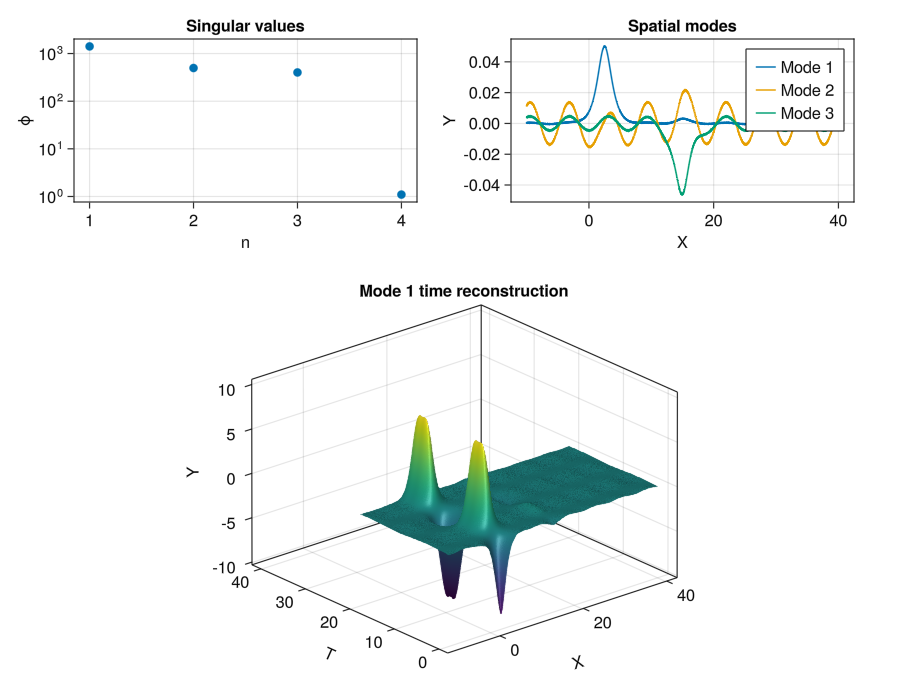

In [32]:
fig = Figure(resolution = (900, 700))
ax1 = Axis(fig[1,1],xlabel="n",ylabel="ϕ", title = "Singular values",yscale=log10,)
ax2 = Axis(fig[1,2],xlabel="X",ylabel="Y", title = "Spatial modes",)
ax3 = Axis3(fig[2:3,1:2],xlabel="X",ylabel="T",zlabel="Y", title = "Mode 1 time reconstruction",)
scatter!(ax1, Σi, label = "Singular values")
for i in 1:3
    lines!(ax2, Xgrid[:,1], Ui[:,i], label = "Mode $i")
end
surface!(ax3, Xgrid, tgrid, M1)

axislegend(ax2)
fig

## Randomised streaming?
I haven't seen this before but it seems like an efficient extension of the streaming algorithm. We use randomised linear algebra to approximate the SVD of each chunk, and then combine the results to get the SVD of the whole dataset.

In [33]:
# Initialise on the first chunk
(m,n)=size(Y1)
Phi=rand(n,k)
Yr=Y1*Phi
Q,R = qr(Yr)
B=transpose(Matrix(Q))*Y1
Û,Σ,Vt=svd(B)
max_idx = sortperm(Σ, rev=true)[1:k]
Uk=Û[:, max_idx]
Vk=Vt'[max_idx, :]
U=Matrix(Q)*Uk

# Incorporate the second chunk
(m,n)=size(Y2)
Phi=rand(n,k)
Yr=Y2*Phi
Qi,Ri = qr(Yr)
Bi=transpose(Matrix(Qi))*Y2
Ûi,Σi,Vti = svd(Bi)
max_idx = sortperm(Σi, rev=true)[1:k]
Σi = Σi[max_idx]
Uki = Ûi[:, max_idx]
Ui=Matrix(Qi)*Uki

Vki=Vti'[max_idx, :]
Ai = diagm(Σi) * Vki
M1 = Ui[:,1:1] * Ai[1:1, :]
;

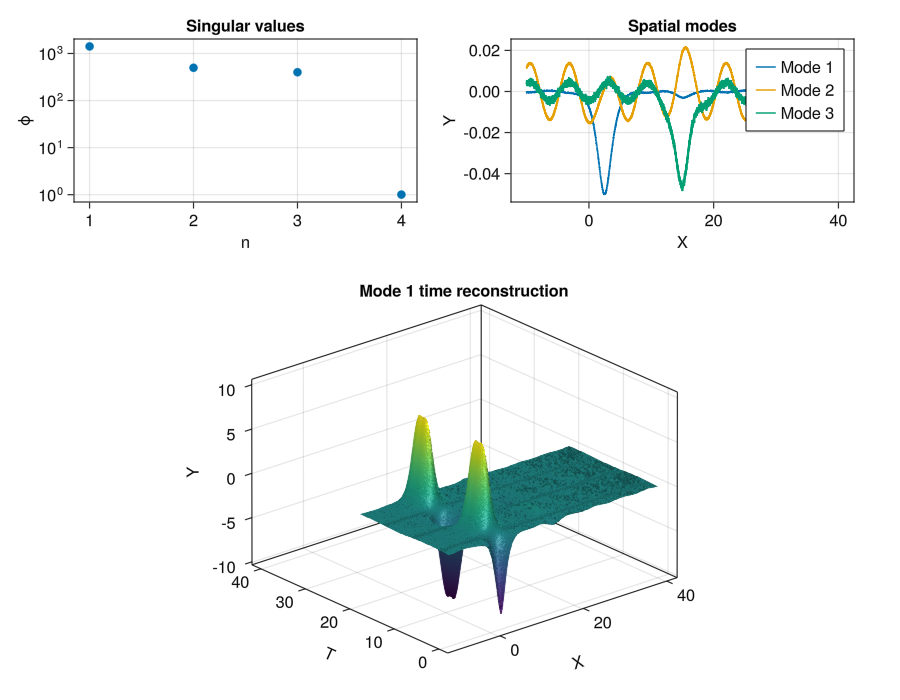

In [34]:
fig = Figure(resolution = (900, 700))
ax1 = Axis(fig[1,1],xlabel="n",ylabel="ϕ", title = "Singular values",yscale=log10,)
ax2 = Axis(fig[1,2],xlabel="X",ylabel="Y", title = "Spatial modes",)
ax3 = Axis3(fig[2:3,1:2],xlabel="X",ylabel="T",zlabel="Y", title = "Mode 1 time reconstruction",)
scatter!(ax1, Σi, label = "Singular values")
for i in 1:3
    lines!(ax2, Xgrid[:,1], Ui[:,i], label = "Mode $i")
end
surface!(ax3, Xgrid, tgrid, M1)

axislegend(ax2)
fig